In [1]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.kymo_class import *
import os
import pandas as pd
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2

%matplotlib widget
%load_ext autoreload
%autoreload 2

C:\Users\coren\Documents\PhD\paper\travelling_wave\AMFTravellingWave\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_root = r"data\csv_new"
paths = [path for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
places = [path.split('.')[0] for path in os.listdir(path_root) if path.split('.')[-1]=='csv']


In [3]:
path_all = r"data\AllSpeeds"
table_speeds = pd.DataFrame()

for i,path in enumerate(paths):
    table_loc = pd.read_csv(os.path.join(path_root,path))
    table_loc['csv_id'] = path
    
    table_loc['days'] = table_loc['time_since_crossing']/pd.Timedelta(days=1)
    
    for j in range(len(table_loc)):
        kymo_id = table_loc['kymo_id'].iloc[j]
        path_subtable = os.path.join(path_all,places[i],f'{places[i]}_kymoID{kymo_id}.csv')
        try:
            subtable = pd.read_csv(path_subtable,sep=',').transpose()
            subtable['folder'] = table_loc['folder'].iloc[j]
            subtable['kymo_id'] = table_loc['kymo_id'].iloc[j]
            subtable['speed'] = subtable.index   
            subtable['speed'] = subtable['speed'].astype(float)
            subtable['tot_num_spore'] = table_loc['tot_num_spore'].iloc[j]
            subtable['days'] = table_loc['days'].iloc[j]
            subtable['unique_id'] = table_loc['unique_id'].iloc[j]
            subtable['csv_id'] = table_loc['csv_id'].iloc[j]
            table_speeds = pd.concat([table_speeds,subtable])
        except:
            continue


In [4]:
path = r"data\AllVelocities"

In [6]:
csv_files = [file for file in os.listdir(path) if file.endswith('.csv')]

# Create a list to store DataFrames
dataframes = []

# Loop through the CSV files, read them into DataFrames, and append to the list
for file in csv_files:
    file_path = os.path.join(path, file)
    df = pd.read_csv(file_path,sep=",",header=None).transpose()
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
final_dataframe = pd.concat(dataframes, ignore_index=True)

Symbiotic N= 71009
Myristate N= 2450


[Text(0, 0, 'Symbiotic'), Text(1, 0, 'Myristate')]

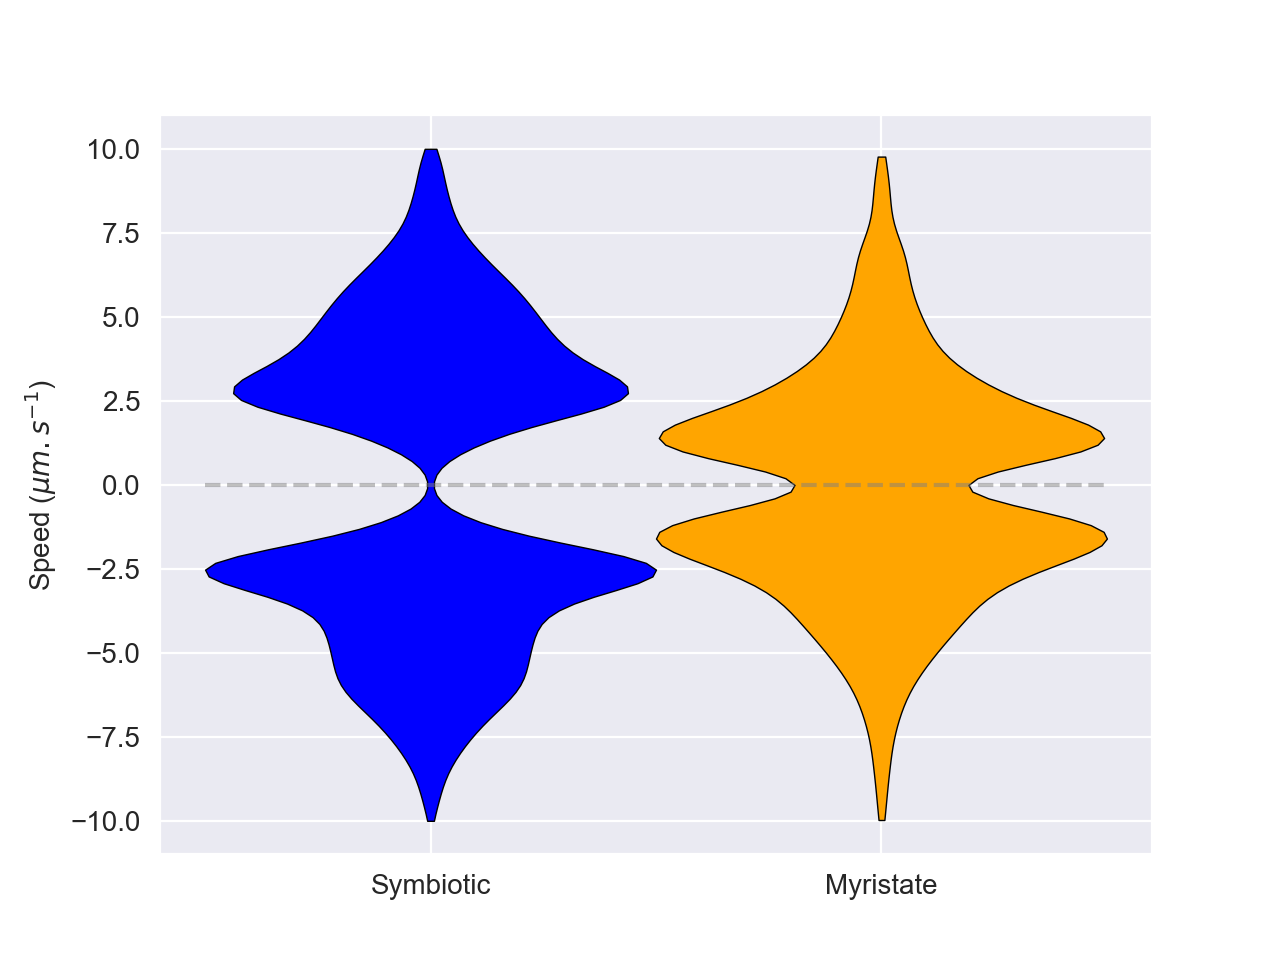

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


select = final_dataframe[abs(final_dataframe[0]) > 0]
select = select[abs(select[0]) <= 10]

select2 = table_speeds[abs(table_speeds['speed']) <=10]

data_for_plotting = pd.concat([
    pd.DataFrame({
        'Speed': select2['speed'],
        'Type': 'Symbiotic'
    }),
    pd.DataFrame({
        'Speed': select[0],
        'Type': 'Myristate'
    })
])
data_for_plotting = data_for_plotting[abs(data_for_plotting['Speed']) >0.8]

fig, ax = plt.subplots() 
colors = ['blue','orange']
types = data_for_plotting['Type'].unique()
for i,treatment in enumerate(types):
    select = data_for_plotting[data_for_plotting['Type']==treatment]
    print(treatment,"N=",len(select))
# Create violin plots
    parts = ax.violinplot(select['Speed'],[i], showextrema=False,widths = 1)
    for pc in parts['bodies']:
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_linewidth(0.5)
ax.set_xlabel("")
ax.set_ylabel("Speed ($\mu m.s^{-1}$)")
ax.hlines(0,-0.5,1.5,color='grey',linestyle='--',alpha = 0.5)
ax.set_xticks(range(len(types)))
ax.set_xticklabels(types)



In [22]:
path = r"data\AllVelocities\kymo.tiff"
kymo = imageio.imread(path)[0]

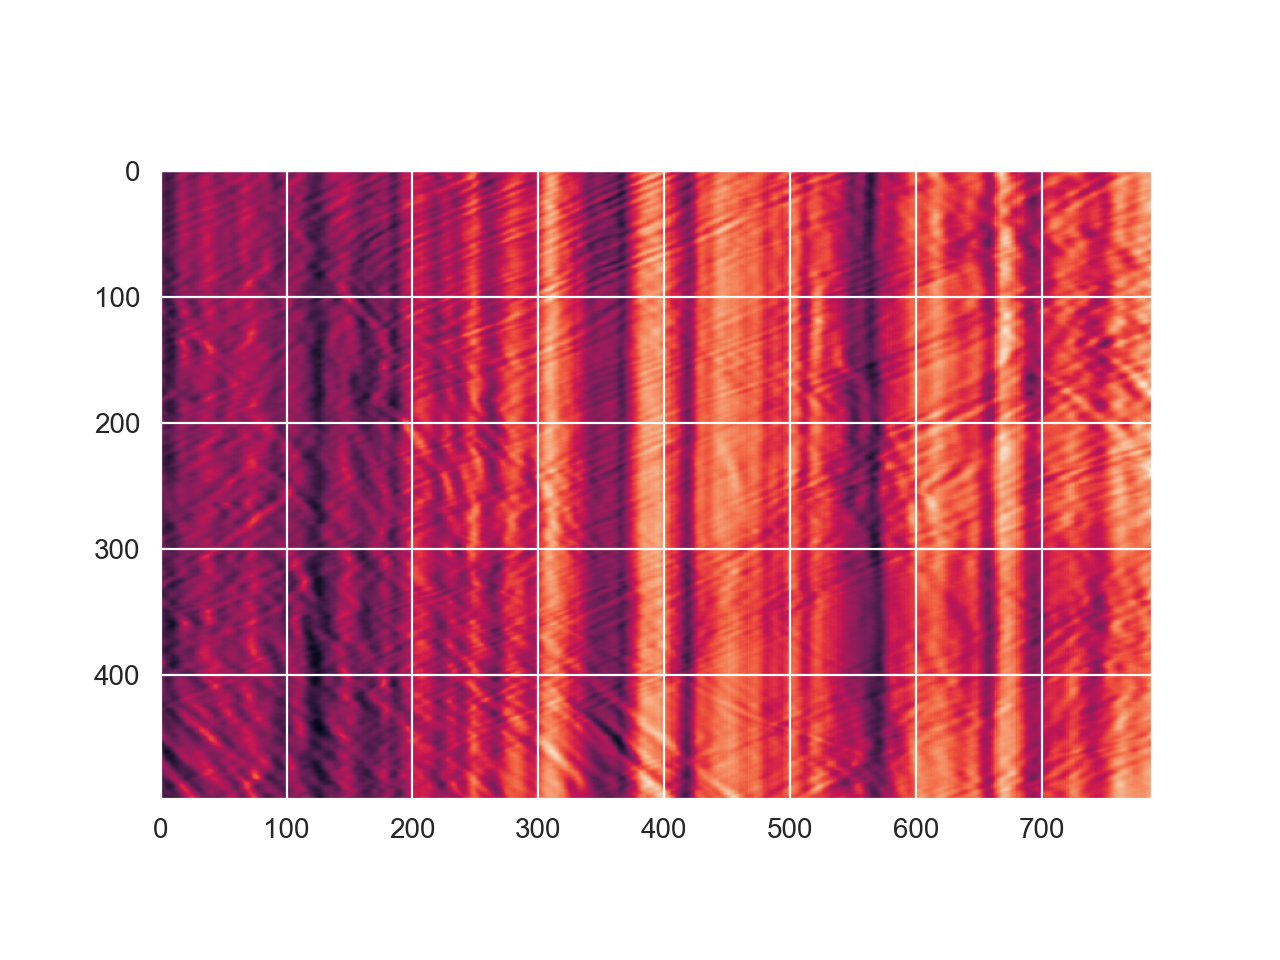

In [23]:
fig,ax = plt.subplots()
ax.imshow(kymo)

In [24]:
def create_paved_kymograph(kymo):
    height, width = kymo.shape

    # Duplicate and manipulate images
    subFourier1 = kymo.copy()
    subFourier2 = cv2.flip(kymo, 1)  # Flip horizontally
    subFourier3 = cv2.flip(subFourier2, 0)  # Flip vertically after horizontal
    subFourier4 = cv2.flip(kymo, 0)  # Flip vertically

    # Create a larger image and place manipulated images accordingly
    filter_forward = np.zeros((3 * height, 3 * width), dtype=kymo.dtype)
    filter_forward[height:2*height, width:2*width] = subFourier1
    filter_forward[height:2*height, 0:width] = subFourier2
    filter_forward[height:2*height, 2*width:3*width] = subFourier2
    filter_forward[0:height, 0:width] = subFourier3
    filter_forward[0:height, 2*width:3*width] = subFourier3
    filter_forward[2*height:3*height, 0:width] = subFourier3
    filter_forward[2*height:3*height, 2*width:3*width] = subFourier3
    filter_forward[0:height, width:2*width] = subFourier4
    filter_forward[2*height:3*height, width:2*width] = subFourier4
    return filter_forward
    
def apply_fourier_operations(tiled_image):
    dft = np.fft.fftshift(np.fft.fft2(tiled_image))  # Apply FFT and shift zero frequency to center
    # Zero out specific regions in the Fourier transform
    h, w = dft.shape
    # Horizontal line across the middle
    dft[h//2-1:h//2+1, :] = 0
    # Top-left quadrant
    dft[:h//2, :w//2] = 0
    # botom-right quadrant
    dft[h//2:, w//2:] = 0
    
    # Inverse Fourier Transform
    inverse_dft = np.fft.ifft2(np.fft.ifftshift(dft)).real

    return inverse_dft

def filter_kymo_left(kymo):
    height, width = kymo.shape
    paved_kymo = create_paved_kymograph(kymo)
    paved_kymo_filter = apply_fourier_operations(paved_kymo)
    paved_kymo = create_paved_kymograph(kymo)
    filtered_kymo = paved_kymo_filter[height:2*height, width:2*width]
    filtered_kymo -= np.percentile(filtered_kymo,10)
    # filtered_kymo[np.where(filtered_kymo<0)] =0
    
    return(filtered_kymo)
    
def filter_kymo_right(kymo):
    return(np.flip(filter_kymo_left(np.flip(kymo, axis=1)), axis=1))

C:\Users\coren\AppData\Local\Temp\ipykernel_31624\429930555.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(tick_labels)


Text(0.5, 0, 'spatial coordinate ($\\mu m$)')

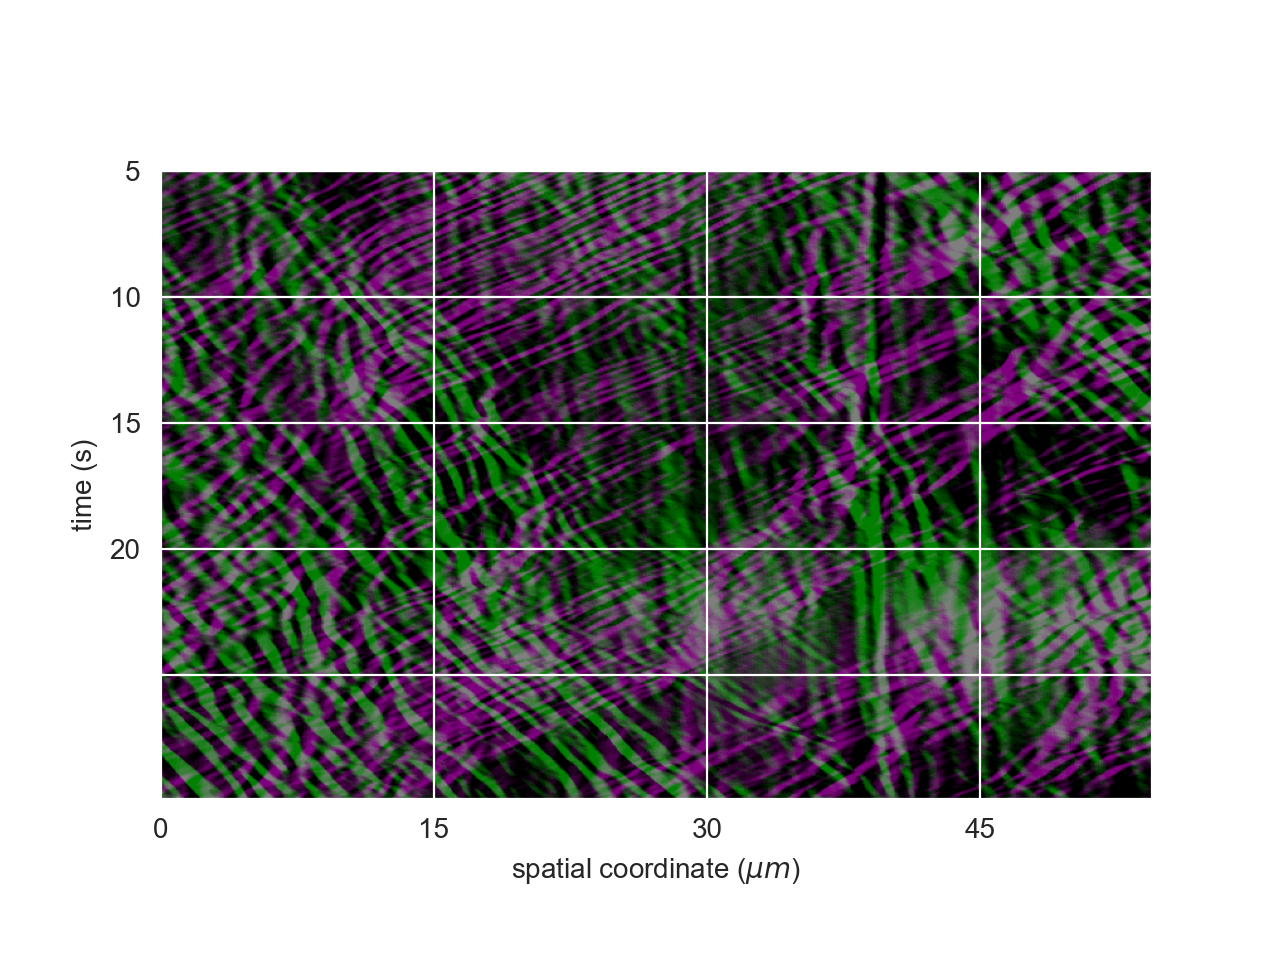

In [27]:
def blend_images(img1, img2):
    # Extract RGB components and ignore the alpha channel
    img1_rgb = img1[:, :, :3]
    img2_rgb = img2[:, :, :3]
    # Blend the images by averaging the RGB values
    blended_rgb = (img1_rgb + img2_rgb) / 2
    # Combine blended RGB with full alpha channel
    return blended_rgb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import Normalize, LinearSegmentedColormap
pixel_size = 1.725/25
pixel_size_time = 1/20
# Filter the kymograph for left and right
filtered_left = filter_kymo_left(kymo)
filtered_right = filter_kymo_right(kymo)

# Get the colormap instances
colors = [(0, 0, 0), (0, 1, 0)]  # Black to red
n_bins = 100  # Number of bins
cmap_reds = LinearSegmentedColormap.from_list("sdv", colors, N=n_bins)
colors = [(0, 0, 0), (1, 0, 1)]  # Black to red

cmap_greens = LinearSegmentedColormap.from_list("dvd", colors, N=n_bins)
# Apply the colormap (including normalization) to create RGBA images
norm = Normalize(vmin=np.percentile(-filtered_left, 20), vmax=np.percentile(-filtered_left, 90))
img_left = cmap_reds(norm(-filtered_left))
norm = Normalize(vmin=np.percentile(-filtered_right, 20), vmax=np.percentile(-filtered_right, 90))
img_right = cmap_greens(norm(-filtered_right))

# Blend the images
blended_img = blend_images(img_left, img_right)

# Plotting the resulting image
fig, ax = plt.subplots()
ax.imshow(blended_img)
num_cols_left = img_left.shape[1]  # assuming image data in numpy array format
ticks = np.arange(0, num_cols_left, int(1/pixel_size*15))  # change 25 to whatever number of pixels you want between ticks
tick_labels = [f"{pixel * pixel_size:.0f}" for pixel in ticks]  # formatting labels to 2 decimal places

ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
num_cols_left = img_left.shape[0]  # assuming image data in numpy array format
ticks = np.arange(0, num_cols_left, int(1/pixel_size_time)*5)  # change 25 to whatever number of pixels you want between ticks
tick_labels = [f"{pixel * pixel_size_time:.0f}" for pixel in ticks]  # formatting labels to 2 decimal places

ax.set_yticklabels(tick_labels)
ax.set_ylabel('time (s)')
ax.set_xlabel('spatial coordinate ($\mu m$)')
# plt.tight_layout()